In [2]:
import pandas as pd
import numpy as np

In [3]:
df=pd.read_csv('/content/sample_data/train.csv').astype(str)
df.head()
# validate=pd.read_csv('/content/drive/My Drive/Colab Notebooks/SML Datasets/nnvalidate.csv').astype(str)

,label,Text
0,FP,always starting new book actually rarely finis...
1,TJ,ah cool yeah knowledgeable either one interest...
2,TP,yes pianist arranger sheet music. hobby. like ...
3,FP,love john lennon imagine song. also love georg...
4,FP,men liked life term personality istps. one fic...


In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [5]:
text=df["Text"]
# val_text=validate["Text"]

In [6]:
tokenizer = Tokenizer(num_words=2500)
tokenizer.fit_on_texts(text)
# max_features  = len(tokenizer.word_index) + 1 
encoded = tokenizer.texts_to_sequences(text)
max_seq_length= max([len(line) for line in encoded])
padded = pad_sequences(encoded, maxlen=max_seq_length, padding='post')

In [7]:
features=padded
len(features[0])

850

In [8]:
cdf=df
one_hot_encoded_data = pd.get_dummies(cdf, columns = ['label'])
one_hot_encoded_data.head()

,Text,label_FJ,label_FP,label_TJ,label_TP
0,always starting new book actually rarely finis...,0,1,0,0
1,ah cool yeah knowledgeable either one interest...,0,0,1,0
2,yes pianist arranger sheet music. hobby. like ...,0,0,0,1
3,love john lennon imagine song. also love georg...,0,1,0,0
4,men liked life term personality istps. one fic...,0,1,0,0


In [9]:
labels=one_hot_encoded_data.iloc[:,1:].to_numpy()
labels

array([[0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       ...,
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0]], dtype=uint8)

In [10]:
MODEL_BATCH_SIZE = 128
TOP_WORDS = 2500
MAX_POST_LENGTH = 40
EMBEDDING_VECTOR_LENGTH = 50

### Learning variables
LEARNING_RATE = 0.01
DROPOUT = 0.3
NUM_EPOCHS = 1

### Control variables
CROSS_VALIDATION = False
SAMPLE = True
WORD_CLOUD = True
SAVE_MODEL = True

In [11]:
tokenizer = Tokenizer(num_words=TOP_WORDS)
tokenizer.fit_on_texts(text)
max_features  = len(tokenizer.word_index) + 1 
encoded = tokenizer.texts_to_sequences(text)
max_seq_length= max([len(line) for line in encoded])
padded = pad_sequences(encoded, maxlen=max_seq_length, padding='post')

In [12]:
  GLOVE_PATH='/content/sample_data/glove.6B.50d.txt'

In [13]:
### Load glove into memory for embedding
embeddings_index = dict()
with open(GLOVE_PATH) as f:
    for line in f:
        values = line.split()
        word = values[0]
        embeddings_index[word] = np.asarray(values[1:], dtype="float32")
print("Loaded {} word vectors.".format(len(embeddings_index)))

Loaded 400000 word vectors.


In [14]:
### Create a weight matrix for words
embedding_matrix = np.zeros((TOP_WORDS, EMBEDDING_VECTOR_LENGTH))
for word, i in tokenizer.word_index.items():
    if i < TOP_WORDS:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [15]:
#from keras.layers import Input
import keras
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers import Dropout
from keras.layers.convolutional import MaxPooling1D
#from keras.layers import Flatten
from keras.layers import Dense
#from keras.models import Model
from sklearn.model_selection import train_test_split

In [16]:
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional
from keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
import tensorflow as tf
from keras import callbacks
from keras.models import Sequential
from keras.layers import GRU
from tensorflow.keras.optimizers import Adam
import torch

In [17]:
    ### Construct model
    with tf.device("/gpu:0"):
        model = Sequential()
        model.add(
            Embedding(
                TOP_WORDS,
                EMBEDDING_VECTOR_LENGTH,
                input_length=max_seq_length,
                weights=[embedding_matrix],
                mask_zero=True,
                trainable=True,
            )
        )
        model.add(Bidirectional(LSTM(EMBEDDING_VECTOR_LENGTH,recurrent_initializer='orthogonal', recurrent_activation='hard_sigmoid',use_bias=True, dropout=DROPOUT, recurrent_dropout=DROPOUT, activation='tanh', kernel_initializer='glorot_uniform')))
        model.add(Dropout(0.5))
        model.add(Dense(4, activation="softmax"))
        optimizer = Adam(lr=LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
        model.compile(
            loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
        )
        print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 850, 50)           125000    
                                                                 
 bidirectional (Bidirectiona  (None, 100)              40400     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 4)                 404       
                                                                 
Total params: 165,804
Trainable params: 165,804
Non-trainable params: 0
_________________________________________________________________
None


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [18]:
x_train , x_test, y_train, y_test = train_test_split(features,labels,test_size=0.3,random_state=6,shuffle=True)

In [19]:
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 2, 
                                        restore_best_weights = True,verbose=2)

In [20]:
history = model.fit(x_train, y_train, epochs = 25, validation_data=(x_test, y_test),shuffle=True, verbose = 1, batch_size=128,callbacks =[earlystopping])

Epoch 1/25
43/43 [==============================] - 224s 5s/step - loss: 1.3841 - accuracy: 0.3066 - val_loss: 1.3514 - val_accuracy: 0.3372
Epoch 2/25
43/43 [==============================] - 216s 5s/step - loss: 1.3281 - accuracy: 0.3684 - val_loss: 1.3134 - val_accuracy: 0.3969
Epoch 3/25
43/43 [==============================] - 214s 5s/step - loss: 1.2338 - accuracy: 0.4586 - val_loss: 1.2650 - val_accuracy: 0.4575
Epoch 4/25
43/43 [==============================] - 212s 5s/step - loss: 1.0836 - accuracy: 0.5428 - val_loss: 1.1204 - val_accuracy: 0.5378
Epoch 5/25
43/43 [==============================] - 211s 5s/step - loss: 0.7886 - accuracy: 0.7042 - val_loss: 0.8743 - val_accuracy: 0.6957
Epoch 6/25
43/43 [==============================] - 211s 5s/step - loss: 0.6194 - accuracy: 0.7778 - val_loss: 0.8694 - val_accuracy: 0.6906
Epoch 7/25
43/43 [==============================] - 210s 5s/step - loss: 0.5226 - accuracy: 0.8139 - val_loss: 0.9845 - val_accuracy: 0.6953
Epoch 8/25
43

In [22]:
model.save('/content/sample_data/lstm')
model.save('/content/sample_data/model.h5')

INFO:tensorflow:Assets written to: /content/sample_data/lstm/assets


INFO:tensorflow:Assets written to: /content/sample_data/lstm/assets


In [23]:
import pickle

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [24]:
loaded_model = tf.keras.models.load_model('/content/sample_data/lstm')

In [25]:
with open('tokenizer.pickle', 'rb') as handle:
    loaded_tokenizer = pickle.load(handle)

In [26]:
test=pd.read_csv('/content/sample_data/test.csv').astype(str)
tsttxt=test['Text']
encoded = loaded_tokenizer.texts_to_sequences(tsttxt)
padded = pad_sequences(encoded, maxlen=max_seq_length)
tstone_hot_encoded_data = pd.get_dummies(test, columns = ['label'])
tstone_hot_encoded_data.head()
tstlabels=tstone_hot_encoded_data.iloc[:,1:].to_numpy()
test_gru_results = loaded_model.evaluate(padded, tstlabels, verbose=0, batch_size=256)
print(f'Test accuracy: {test_gru_results[1]*100:0.2f}')

Test accuracy: 67.74


In [27]:
pred = model.predict(padded)


In [28]:
pred
y_pred=(pred>0.5)

In [29]:
import matplotlib.pyplot as plt


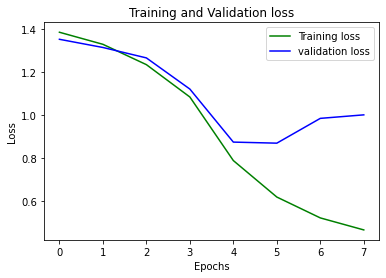

In [30]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
plt.plot(loss_train, 'g', label='Training loss')
plt.plot(loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

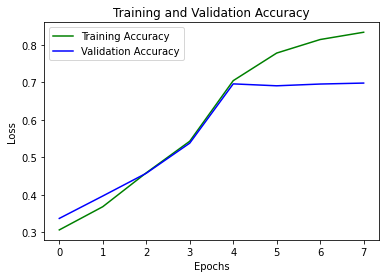

In [31]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
plt.plot(loss_train, 'g', label='Training Accuracy')
plt.plot(loss_val, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [32]:
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, classification_report

In [33]:
matrix = metrics.confusion_matrix(tstlabels.argmax(axis=1), y_pred.argmax(axis=1))

In [34]:
matrix

array([[122,  40,  16,  15],
       [ 30, 209,  10,  23],
       [ 26,  13,  76,  24],
       [ 42,  32,  19, 171]])

In [35]:
print(classification_report(tstlabels.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.55      0.63      0.59       193
           1       0.71      0.77      0.74       272
           2       0.63      0.55      0.58       139
           3       0.73      0.65      0.69       264

    accuracy                           0.67       868
   macro avg       0.66      0.65      0.65       868
weighted avg       0.67      0.67      0.67       868



In [36]:
import seaborn as sns
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

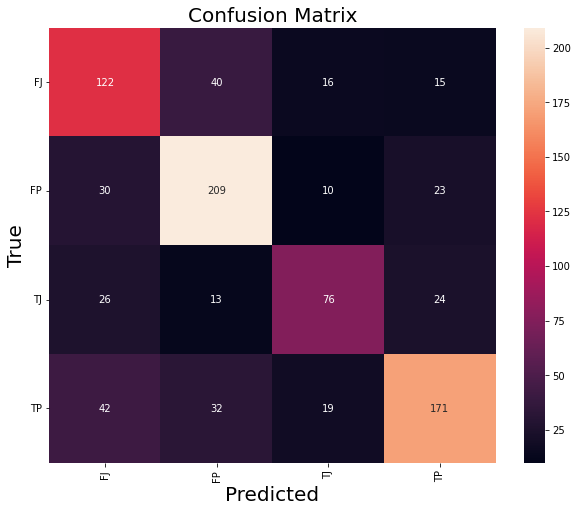

In [37]:
cm = confusion_matrix(tstlabels.argmax(axis=1), y_pred.argmax(axis=1))

## Get Class Labels

class_names = ['FJ','FP','TJ','TP' ]

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(10, 8))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Confusion Matrix', fontsize=20)

plt.savefig('ConMat24.png')
plt.show()